# <img src="https://img.icons8.com/bubbles/100/000000/3d-glasses.png" style="height:50px;display:inline"> EE 046746 - Technion - Computer Vision


## Homework 1 - Image Classification
---

### <a style='color:red'> Due Date: 23.11.2022 </a>

### <img src="https://img.icons8.com/bubbles/50/000000/upload-to-cloud.png" style="height:50px;display:inline"> Submission Guidelines
---
#### READ THIS CAREFULLY
* Submission only in **pairs**.
* **No handwritten submissions**.
* You can choose your working environment:
    * You can work in a `Jupyter Notebook`, locally with <a href="https://www.anaconda.com/distribution/">Anaconda</a> or online on <a href="https://colab.research.google.com/">Google Colab</a>
  * **Important**: Colab also supports running code on GPU, so if you don't have one, Colab is the way to go. To enable GPU on Colab, in the menu: `Runtime` $\rightarrow$  `Change Runtime Type` $\rightarrow$`GPU`.
    * You can work in a Python IDE such as <a href="https://www.jetbrains.com/pycharm/">PyCharm</a> or <a href="https://code.visualstudio.com/">Visual Studio Code</a>.
        * Both also allow opening/editing Jupyter Notebooks.

* Make sure you submit your exercise according to the requirements in the <a href="https://moodle.technion.ac.il/pluginfile.php/1823033/mod_resource/content/2/Homework%20guidelines.pdf">"Homework submission guidelines"</a> file that appears in the course website (Moodle). 
* **The code should run both on CPU and GPU without manual modifications**, require no special preparation and run on every computer.
* **DON'T** submit the CIFAR-10 dataset in your submission, we have a local copy of it.
* **DON'T** submit the trained networks, but make sure to document every result you get.
* Be precise, we expect on point answers.
* Submission on the course website (Moodle).

### <img src="https://img.icons8.com/dusk/64/000000/python.png" style="height:50px;display:inline"> Python Libraries
---

* `numpy`
* `matplotlib`
* `pytorch` (and `torchvision`)
* `opencv` (or `scikit-image`)
* `scikit-learn`
* Anything else you need (`PIL`, `os`, `pandas`, `csv`, `json`,...)

In [1]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.transforms as transforms
import time
import os
from PIL import Image
import glob
from sklearn import svm


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cuda



### <img src="https://img.icons8.com/bubbles/50/000000/checklist.png" style="height:50px;display:inline"> Tasks
---
* In all tasks, you should document your process and results in a report file (which will be saved as `.pdf`). 
* You can reference your code in the report file, but no need for actual code in this file, the code is submitted in a seprate folder as explained above.

#### Part 1 - Classic Classifier
---
In this part we are going to examine the performance of a classical classifier over images from the **Canadian Institute For Advanced Research (CIFAR-10)**  Dataset. 

* The CIFAR-10 dataset consists of 60,000 32x32 colour images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images.
  * There is also CIFAR-100, with 100 classes.
* The classes are completely mutually exclusive. For example, there is no overlap between automobiles and trucks. "Automobile" includes sedans, SUVs, things of that sort. "Truck" includes only big trucks. Neither includes pickup trucks.
* <a href="https://www.cs.toronto.edu/~kriz/cifar.html">Official Site</a>


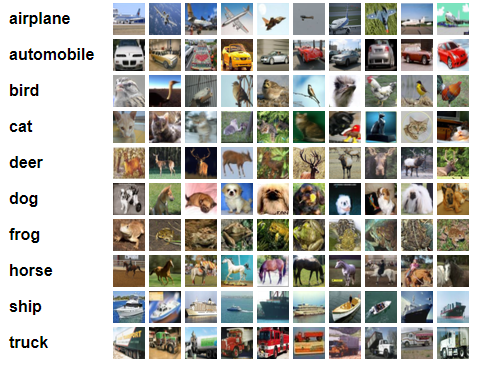


1. Load the CIFAR-10 training and test set with PyTorch (<a href="https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html#torchvision.datasets.CIFAR10">read more here</a>). Display 5 images from the training set with their labels as title.

Files already downloaded and verified
Files already downloaded and verified


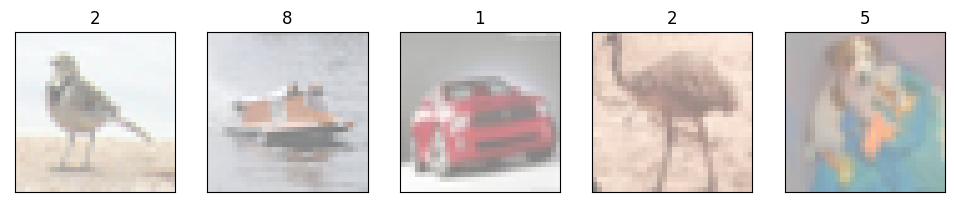

In [2]:
def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range - approximately...
    image = image / (image.abs().max() * 2) + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),
#     transforms.ColorJitter(brightness=63. / 255., saturation=[0.5, 1.5], contrast=[0.2, 1.8]),
#     transforms.ToTensor(), # (almost) Always use this!
#      # Cifar10 dataset's: Mean - R Mean - G Mean - B STD - R STD- G STD - B
#      transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233,0.24348505, 0.26158768)),])
# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.49139968, 0.48215827 ,0.44653124), (0.24703233, 0.24348505, 0.26158768)),])

transform_train = transforms.ToTensor()
transform_test = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10(root='./datasets', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./datasets', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=5, shuffle=True)
dataiter = iter(trainloader)
images, labels = next(dataiter)
fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))

for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(labels[idx].data.item())
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])



2. Build a K-Nearest Neighbors (K-NN) classifier (hint: `sklearn.neighbors.KNeighborsClassifier`), with `n_neighbors=10`, to classify CIFAR-10: Load 10,000 samples from the training set and train the model. 

  **Note**: The model's input dimension should be : `(n_samples, n_features)`, Thus you need to convert each color channel to row representation and then concatenate the 3 color channels.

3. Load 1,000 samples from CIFAR-10 test set and check the performance of the K-NN classifier over these samples. What is the accuracy obtained? View the results using a confusion matrix

4. Compare the model's accuracy for different number of neighbors ($1 \leq K \leq 30$ ). Display the results in a graph of accuracy as function of $K$.

#### Part 2 - Design and Build a CNN Classifier
---
In this part you are going to design a deep convolutional neural network to classify CIFAR-10 dataset. 

1. Use the CNN from tutorials 3-4 (`SvhnCnn()`) and train it on the CIFAR-10 dataset (**keep the architecture the same**) for the same number of **epochs** with the same learning rate (try to keep the batch size the same, but if you get memory errors, you can reduce it). What is the accuracy on the test set? What classes are most confusing for this model?
    * Your test accuracy from this section will be your **baseline** accuracy for sections 2-3.

In [3]:
from models import SvhnCNN

In [4]:
# time to train our model
# hyper-parameters
batch_size = 128
learning_rate = 1e-4
epochs = 20
# dataloaders - creating batches and shuffling the data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')
# loss criterion
criterion = nn.CrossEntropyLoss()
# build our model and send it to the device
model = SvhnCNN().to(device) # no need for parameters as we alredy defined them in the class
# optimizer - SGD, Adam, RMSProp...
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Using cuda:0


In [5]:
# function to calcualte accuracy of the model
def calculate_accuracy(model, dataloader, device):
    model.eval() # put in evaluation mode
    total_correct = 0
    total_images = 0
    confusion_matrix = np.zeros([10,10], int)
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            for i, l in enumerate(labels):
                confusion_matrix[l.item(), predicted[i].item()] += 1
    model_accuracy = total_correct / total_images * 100
    return model_accuracy, confusion_matrix

In [6]:
# training loop
for epoch in range(1, epochs + 1):
    model.train() # put in training mode
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # forward + backward + optimize
        outputs = model(inputs) # forward pass
        loss = criterion(outputs, labels) # calculate the loss
        # always the same 3 steps
        optimizer.zero_grad() # zero the parameter gradients
        loss.backward() # backpropagation
        optimizer.step() # update parameters
        # print statistics
        running_loss += loss.data.item()
        
    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)
    # Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, trainloader, device)
    test_accuracy, conf_matrix = calculate_accuracy(model, testloader, device)
    log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy, test_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    print(log)

    # save model
    if epoch % 20 == 0:
        print('==> Saving model ...')
        state = {
        'net': model.state_dict(),
        'epoch': epoch,
        }
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, './checkpoints/svhn_cnn_ckpt.pth')
        
print('==> Finished Training ...')

Epoch: 1 | Loss: 1.5745 | Training accuracy: 50.960% | Test accuracy: 50.840% | Epoch Time: 18.32 secs
Epoch: 2 | Loss: 1.2440 | Training accuracy: 59.780% | Test accuracy: 58.870% | Epoch Time: 17.42 secs
Epoch: 3 | Loss: 1.0862 | Training accuracy: 65.244% | Test accuracy: 63.880% | Epoch Time: 17.47 secs
Epoch: 4 | Loss: 0.9686 | Training accuracy: 68.972% | Test accuracy: 66.240% | Epoch Time: 17.49 secs
Epoch: 5 | Loss: 0.8785 | Training accuracy: 72.238% | Test accuracy: 68.930% | Epoch Time: 17.42 secs
Epoch: 6 | Loss: 0.8022 | Training accuracy: 74.224% | Test accuracy: 70.450% | Epoch Time: 17.46 secs
Epoch: 7 | Loss: 0.7368 | Training accuracy: 76.998% | Test accuracy: 72.030% | Epoch Time: 17.51 secs
Epoch: 8 | Loss: 0.6773 | Training accuracy: 79.334% | Test accuracy: 73.550% | Epoch Time: 17.44 secs
Epoch: 9 | Loss: 0.6265 | Training accuracy: 80.066% | Test accuracy: 72.650% | Epoch Time: 17.45 secs
Epoch: 10 | Loss: 0.5791 | Training accuracy: 83.148% | Test accuracy: 75

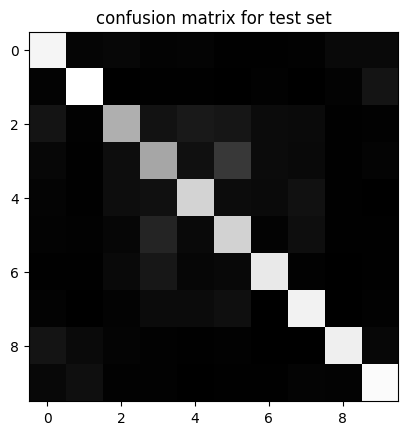

In [12]:
# display confusion matrix
plt.imshow(conf_matrix, cmap='gray')
plt.title("confusion matrix for test set")
plt.show()

2. Design your own Convolutional Neural Network (CNN) to classify CIFAR-10. You can modify the network from section 1,but **you must get a better result than your baseline accuracy from section 1**.
    * You **need** to use one of the following in your CNN - Residual block, activation function PReLU, activation function Leaky ReLU, Group Normalization, Exponential moving average (EMA).
      Explain the technique you have chosen.
    * Describe the chosen architecture, how many layers? What activations did you choose? What are the filter sizes? Did you use fully-connected layers (if you did, explain their sizes)?
    * What is the input dimension? What is the output dimension?
    * Calculate the number of parameters (weights) in the network.

  **Note:** 
    * The new network should perform better over the same task (i.e. using the same data with the same hyper-parameters. Change only the network architecture).
    * Students who reach the highest accuracy over the test set will receive **5 bonus points** for this exercise.


In [17]:
from models import ResidualBlock
class SuperSvhnCNN(nn.Module):
    """CNN for the SVHN Datset"""
    
    def __init__(self):
        """CNN Builder."""
        super().__init__()
        self.conv_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),      
            nn.BatchNorm2d(16),
            nn.PReLU(16),
#             ResidualBlock(3, [16], kernel_size=3, batchnorm=True)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.PReLU(32),
#             ResidualBlock(3, [16, 32], batchnorm=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # Conv Layer block 2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.PReLU(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.PReLU(64),
#             ResidualBlock(32, [64, 64], batchnorm=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05), # <- Why is this here?
#             Modified Conv Layer block 3
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.PReLU(128),
            ResidualBlock(128, [256, 256], batchnorm=True, dropout=0.05)
            )
        self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(8192*2, 2048),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(2048, 512), # <- How do we know it's 8192? Why 512 later?
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.5),
        nn.Linear(512, 10) # <- Why 10 here?
        )
        
    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.conv_layer(x)
        # flatten
        x = x.view(x.size(0), -1)
        # fc layer
        x = self.fc_layer(x)
        return x



model = SuperSvhnCNN()
print(model)
print("number of parameters: {}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

SuperSvhnCNN(
  (conv_layer): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=16)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): PReLU(num_parameters=32)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): PReLU(num_parameters=64)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): PReLU(num_parameters=64)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): PReLU(num_parameters=128)
    (15): ResidualB

3. Train the classifier (preferably on a **GPU - use Colab for this part** if you don't have a GPU).
    * Describe the hyper-parameters of the model (batch size, epochs, learning rate....). How did you tune your model? Did you use a validation set to tune the model? (<a href="https://gist.github.com/MattKleinsmith/5226a94bad5dd12ed0b871aed98cb123">Separating to train/validation/test in PyTorch</a>)
    * What is the final accuracy on the test set?

In [18]:
# time to train our model
# hyper-parameters
batch_size = 128
learning_rate = 1e-4
epochs = 20
# dataloaders - creating batches and shuffling the data
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
# device - cpu or gpu?
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using {device}')
# loss criterion
criterion = nn.CrossEntropyLoss()
# build our model and send it to the device
model = SuperSvhnCNN().to(device) # no need for parameters as we alredy defined them in the class
# optimizer - SGD, Adam, RMSProp...
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Using cuda:0


In [19]:
# training loop
for epoch in range(1, epochs + 1):
    model.train() # put in training mode
    running_loss = 0.0
    epoch_time = time.time()
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        # send them to device
        inputs = inputs.to(device)
        labels = labels.to(device)
        # forward + backward + optimize
        outputs = model(inputs) # forward pass
        loss = criterion(outputs, labels) # calculate the loss
        # always the same 3 steps
        optimizer.zero_grad() # zero the parameter gradients
        loss.backward() # backpropagation
        optimizer.step() # update parameters
        # print statistics
        running_loss += loss.data.item()
        
    # Normalizing the loss by the total number of train batches
    running_loss /= len(trainloader)
    # Calculate training/test set accuracy of the existing model
    train_accuracy, _ = calculate_accuracy(model, trainloader, device)
    test_accuracy, conf_matrix = calculate_accuracy(model, testloader, device)
    log = "Epoch: {} | Loss: {:.4f} | Training accuracy: {:.3f}% | Test accuracy: {:.3f}% | ".format(epoch, running_loss, train_accuracy, test_accuracy)
    epoch_time = time.time() - epoch_time
    log += "Epoch Time: {:.2f} secs".format(epoch_time)
    print(log)

    # save model
    if epoch % 20 == 0:
        print('==> Saving model ...')
    state = {
    'net': model.state_dict(),
    'epoch': epoch,
    }
    if not os.path.isdir('checkpoints'):
        os.mkdir('checkpoints')
    torch.save(state, './checkpoints/super_svhn_cnn_ckpt.pth')
print('==> Finished Training ...')

Epoch: 1 | Loss: 1.5034 | Training accuracy: 59.980% | Test accuracy: 58.540% | Epoch Time: 21.35 secs
Epoch: 2 | Loss: 1.0478 | Training accuracy: 70.224% | Test accuracy: 67.600% | Epoch Time: 21.20 secs
Epoch: 3 | Loss: 0.8572 | Training accuracy: 75.676% | Test accuracy: 72.080% | Epoch Time: 21.29 secs
Epoch: 4 | Loss: 0.7389 | Training accuracy: 80.302% | Test accuracy: 74.800% | Epoch Time: 21.25 secs
Epoch: 5 | Loss: 0.6447 | Training accuracy: 83.638% | Test accuracy: 76.210% | Epoch Time: 21.24 secs
Epoch: 6 | Loss: 0.5756 | Training accuracy: 86.194% | Test accuracy: 77.360% | Epoch Time: 21.30 secs
Epoch: 7 | Loss: 0.5065 | Training accuracy: 88.530% | Test accuracy: 78.520% | Epoch Time: 21.31 secs
Epoch: 8 | Loss: 0.4452 | Training accuracy: 90.292% | Test accuracy: 78.430% | Epoch Time: 21.36 secs
Epoch: 9 | Loss: 0.3916 | Training accuracy: 93.024% | Test accuracy: 79.750% | Epoch Time: 21.22 secs
Epoch: 10 | Loss: 0.3400 | Training accuracy: 93.896% | Test accuracy: 79

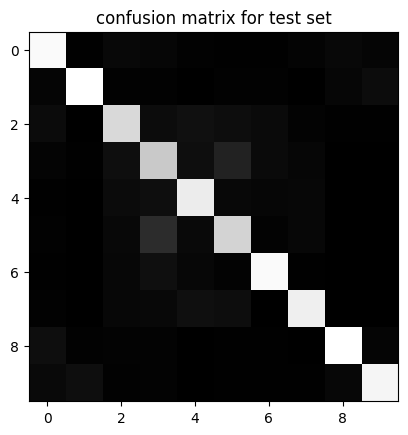

In [21]:
# display confusion matrix
plt.imshow(conf_matrix, cmap='gray')
plt.title("confusion matrix for test set")
plt.show()

#### Part 3 - Analyzing a Pre-trained CNN
---
In this part you are going to analyze a (large) pre-trained model. Pre-trained models are quite popular these days, as big companies can train really large models on large datasets (something that personal users can't do as they lack the sufficient hardware). These pre-trained models can be used to fine-tune on other/small datasets or used as components in other tasks (like using a pre-trained classifier for object detection).

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`. 

You can use the following transform to normalize:

`normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`

<a href="https://pytorch.org/vision/stable/models.html">Read more here</a>

1. Load a pre-trained VGG16 with PyTorch using `torchvision.models.vgg16(pretrained=True, progress=True, **kwargs)` (<a href="https://pytorch.org/vision/stable/models.html#classification">read more here</a>). Don't forget to use the model in evaluation mode (`model.eval()`). 

In [22]:
model = torchvision.models.vgg16(pretrained=True, progress=True)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

2. Load the images in the `./data/birds` folder and display them.

[]

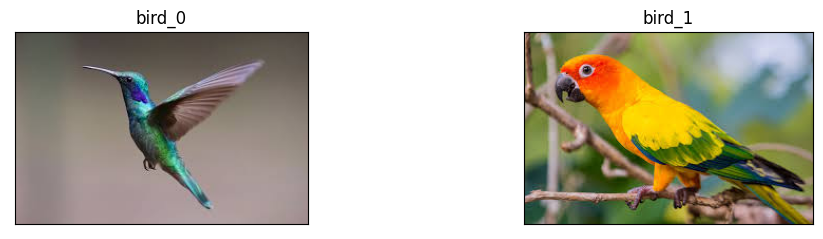

In [23]:
bird_0_img = Image.open("data/birds/bird_0.jpg")
bird_1_img = Image.open("data/birds/bird_1.jpg")

fig, axes = plt.subplots(1, 2, figsize=(12,2.5))

axes[0].imshow(bird_0_img)
axes[0].set_title("bird_0")
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].imshow(bird_1_img)
axes[1].set_title("bird_1")
axes[1].set_xticks([])
axes[1].set_yticks([])

3. Pre-process the images to fit VGG16's architecture. What steps did you take?

In [24]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


trns_bird_0 = transform(bird_0_img)
trns_bird_1 = transform(bird_1_img)


4. Feed the images (forward pass) to the model. What are the outputs? To convert from class index to label, use the supplied `./data/imagenet1000_clsidx_to_labels.txt` file

In [25]:
x = torch.stack((trns_bird_0, trns_bird_1))
y = model(x)
y_pred = torch.argmax(torch.softmax(y, dim = 1), dim=1)
print(y_pred)

tensor([94, 90])


5. Find an image of a bird/cat/dog on the internet, display it and feed it to network. What are the outputs?

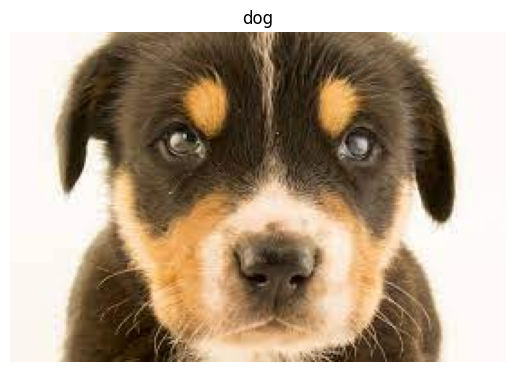

tensor([241])


In [26]:
dog_img = Image.open("data/my_data/our_dog_1.jpeg")
plt.imshow(dog_img)
plt.axis('off')
plt.title("dog")
plt.show()

trns_dog = transform(dog_img)
y = model(trns_dog.unsqueeze(dim=0))
y_pred = torch.argmax(torch.softmax(y, dim = 1), dim=1)
print(y_pred)

6. For the first 3 filters in the *first layer* of VGG16, plot the filters, and then plot their response (their output) for the image from section 5. Explain what do you see.
    * Consult `ee046746_appndx_visualizing_cnn_filters.ipynb` to refresh your memory.

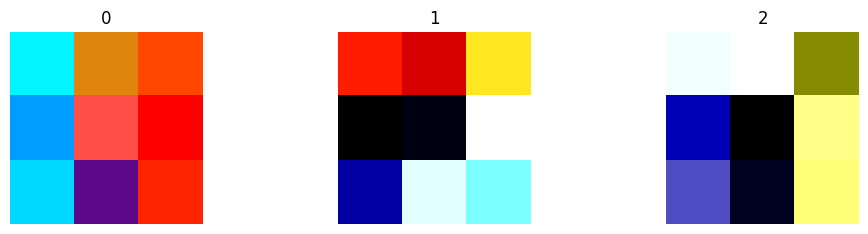

In [27]:
# plotting filters
weight_tensor = model.features[0].weight.data

fig, axes = plt.subplots(1, 3, figsize=(12,2.5))

for i in range(3):
    # for each kernel, we convert the tensor to numpy
    npimg = np.array(weight_tensor[i].numpy(), np.float32)
    # standardize the numpy image
    npimg = (npimg - np.mean(npimg)) / np.std(npimg)
    npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
    npimg = npimg.transpose((1, 2, 0))
    
    axes[i].set_title(str(i))
    axes[i].imshow(npimg)
    axes[i].axis('off')

plt.show()

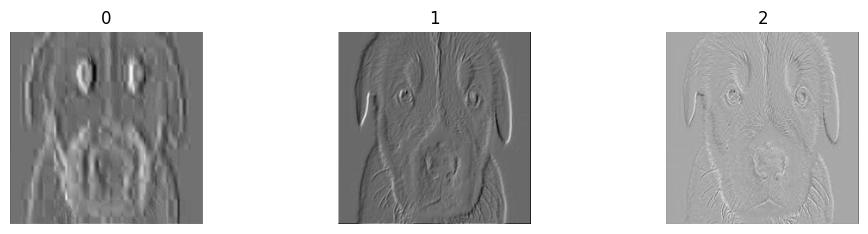

In [28]:
# plotting response
modulelist = list(model.features.modules())
output = modulelist[1](trns_dog)                

filters = []
output = output.data.squeeze().cpu().numpy()
for i in range(output.shape[0]):
    filters.append(output[i,:,:])

fig, axes = plt.subplots(1, 3, figsize=(12,2.5))
for i in range(3):
    axes[i].set_title(str(i))
    axes[i].imshow(filters[i], "gray")
    axes[i].axis('off')

plt.show()

7. For each image in the `./data/dogs` and `./data/cats`folders, extract and save their feature vectors (create a numpy array or a torch tensor that contains the features for all samples) from a fully-connected layer (such as `FC7`) of the VGG16 model. Which layer did you pick? What is the size of the feature space?
    * You need to write a function that does the feed forward manually until the desired layer. See the example in `ee046746_appndx_visualizing_cnn_filters.ipynb`. 

In [29]:
# loading dog and cat images

dog_images = []
for f in glob.iglob("data/dogs/*"):
    dog_images.append(np.asarray(Image.open(f)))
                    
cat_images = []
for f in glob.iglob("data/cats/*"):
    cat_images.append(np.asarray(Image.open(f)))


In [30]:
# transform images

trns_dogs = []
for dog_im in dog_images:
    trns_dogs.append(transform(dog_im))
trns_dogs = torch.stack(trns_dogs)

trns_cats = []
for cat_im in cat_images:
    trns_cats.append(transform(cat_im))

trns_cats = torch.stack(trns_cats)

/home/ronbenc/miniconda3/envs/ComputerVision/lib/python3.9/site-packages/torchvision/transforms/functional.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


8. Build a Support Vector Machine (SVM) classifier (hint: `sklearn.svm.LinearSVC`) to classify cats and dogs based on the features you extracted. Use the 20 images as train set, and choose 4 images (2 dogs, 2 cats) from the internet as test sets. You can choose a different classifer than SVM from the `scikit-learn` library, no need to explain how it works (but report the name of the algorithm you used). What are the results?

In [31]:
# extracts features

feature_extractor = model.features

dog_features = feature_extractor(trns_dogs)
cat_features = feature_extractor(trns_cats)

dog_features = dog_features.view(dog_features.size(0), -1)
print(dog_features.shape)

cat_features = cat_features.view(cat_features.size(0), -1)
print(cat_features.shape)

torch.Size([10, 25088])
torch.Size([10, 25088])


In [32]:
# train svc

svc_model = svm.LinearSVC()

X = torch.cat((dog_features, cat_features), 0).detach().numpy()
y = torch.cat((torch.zeros(10), torch.ones(10)), 0).detach().numpy()

svc_model.fit(X=X, y=y)

LinearSVC()

(4, 25088)


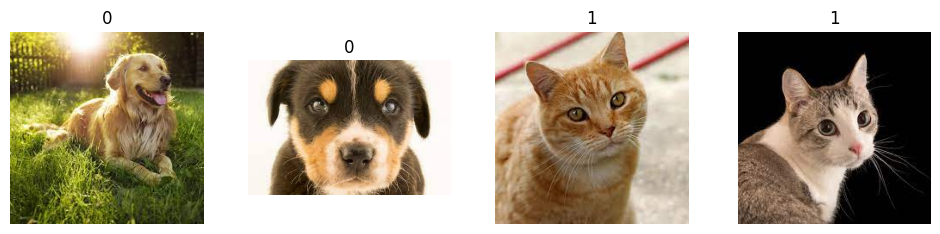

In [33]:
# test svc

# load images
cat_dog_images = []
for f in glob.iglob("data/my_data/*.jpeg"):
    cat_dog_images.append(np.asarray(Image.open(f)))

# transform images
trns_cat_dog = []
for im in cat_dog_images:
    trns_cat_dog.append(transform(im))
trns_cat_dog = torch.stack(trns_cat_dog)

# extract features
features = feature_extractor(trns_cat_dog)
features = features.view(features.size(0), -1).detach().numpy()
print(features.shape)

y_pred = svc_model.predict(features)


fig, axes = plt.subplots(1, 4, figsize=(12,2.5))
for i in range(4):
    axes[i].set_title(str(int(y_pred[i])))
    axes[i].imshow(cat_dog_images[i])
    axes[i].axis('off')

plt.show()


#### Part 4 - Dry Questions

---
1. A researcher is thinking to design a bag of words algorithm for flags detection.
Describe the pros and cons of the methods in this case. Below are some flag images you can use.


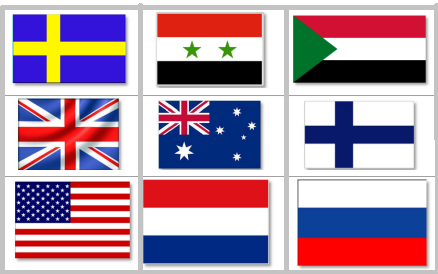



2. Danny is interested to design a dogs classifier. He has dataset of RGB images of 3 types of dogs in dimensions of 64X64 (i.e. the dimension of each image is 3X64X64). In the following table, the network architecture is defined in the leftmost column. You need to fill in the two additional columns: In the middle column fill the output dimensions and in the right column the number of learnd parameters (weights). The answer should be written as multiples (for example: 128 × 128 × 3 ).No need to consider bias. 

  **Conv7-N**: A convolution layer with N neurons, each one has dimensions of 7 × 7 × D where D is the volume depth activation in the previous layer. Padding = 2 and  Stride = 1.

  **POOL2**: 2 × 2  Max-Pooling activation with Stride=2. If the input to the layer is an odd number, round it down.

  **FC-N**: Fully Connected layer with N neurons. 

\begin{array}{|c|c|} \hline
\text{Layer} & \text{Output dimensions}  & \text{Number of parameters (weights)}  \\ \hline
INPUT & 64 × 64 × 3 & 0  \\ \hline
CONV7-16 &  &   \\\hline
POOL2 &  &   \\ \hline
CONV7-32 &  &   \\ \hline
POOL2 &  &   \\ \hline
FC-3 &  &   \\ \hline
\end{array}

1.  


     pros:
         Robustness to translations.
    cons:
        Might cause wrong detections - for instance, might identify the flag of Russia as the flag of Netherlands. 
        


2.

\begin{array}{|c|c|} \hline
\text{Layer} & \text{Output dimensions}  & \text{Number of parameters (weights)}  \\ \hline
INPUT & 64 × 64 × 3 & 0  \\ \hline
CONV7-16 & 62 × 62 × 16  & 3⋅16⋅7⋅7 =2,352  \\\hline
POOL2 & 31 × 31 × 16 &  0 \\ \hline
CONV7-32 & 29 × 29 × 32  & 16⋅32⋅7⋅7 =25,088  \\ \hline
POOL2 & 14 × 14 × 32  & 0   \\ \hline
FC-3 & 3 &  14⋅14⋅3⋅32 = 18,816 \\ \hline
\end{array}